In [1]:
import pandas as pd
import numpy as np
import scenario_simulation as ss
import longevity_lib as long
import matplotlib.pyplot as plt
import tontine as ton
import importlib as imp
import strategies as strat

# Define Normal and Crash Period Assumptions

In [2]:
r_n = pd.read_csv('Data/normal_expected_returns.csv')
asset_columns = list(r_n.columns)
r_n = r_n.values[0]

r_c = pd.read_csv('Data/crash_expected_returns.csv').values[0]
Q_n = pd.read_csv('Data/normal_covariance.csv')
Q_c = pd.read_csv('Data/crash_covariance.csv')
del Q_n['Unnamed: 0']
del Q_c['Unnamed: 0']

Q_n = Q_n.values[0:9, 0:9]
Q_c = Q_c.values[0:9, 0:9]
P = [[.984, .016], [.09, .91]]

In [3]:
age_0 = 72
nscen = 100

In [4]:
scenarios = ss.gen_scenarios(nscen, age_0, r_n, Q_n, P, r_c, Q_c)

# Generate Macro economic Variables

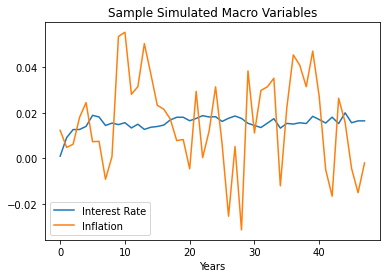

In [5]:
mu_int =  1.59/100# Bond Mean
sig_int =  1.53/100# Bond Volatility
mu_inf = 2.00/100 + 1 #Stand in inflation
sig_inf = 1.53/100 #Stand in volatility


# Mean−reverting example
n_years = 120 - age_0
interest_vec = np.ones(n_years) * 0.001
inflation_vec = np.ones(n_years) * 1.0123

for i in range(n_years-1):
    interest_vec[i+1] = interest_vec[i] + 0.5*(mu_int-interest_vec[i]) + sig_int*np.sqrt(
        interest_vec[i])*np.random.randn(1)
    if interest_vec[i+1]<=0: # No negative rate
        interest_vec[i+1] = 0
    inflation_vec[i+1] = inflation_vec[i] + 0.5*(mu_inf-inflation_vec[i]) + sig_inf*np.random.randn(1)
    
    
plt.plot(interest_vec,label='Interest Rate')
plt.plot(inflation_vec - 1,label='Inflation')
plt.legend(loc='best')
plt.xlabel('Years')
plt.title('Sample Simulated Macro Variables')
plt.savefig('Analysis/macro.png')
plt.show()
# Generate macro variables for 10,000 scenarios
inf_mat = np.zeros((nscen, n_years))
ir_mat = np.zeros((nscen, n_years))

for j in range(nscen):
    np.random.seed(j)
    interest_vec = np.ones(n_years) * 0.001
    inflation_vec = np.ones(n_years) * 1.0123
    for i in range(n_years-1):
        interest_vec[i+1] = interest_vec[i] + 0.5*(mu_int-interest_vec[i]) + sig_int*np.sqrt(interest_vec[i])*np.random.randn(1)
        if interest_vec[i+1]<=0: # No negative rate
            interest_vec[i+1] = 0
        inflation_vec[i+1] = inflation_vec[i] + 0.5*(mu_inf-inflation_vec[i]) + sig_inf*np.random.randn(1)

    inf_mat[j,:] = inflation_vec-1
    ir_mat[j ,:] = interest_vec


In [6]:
mortality_table = pd.read_csv('Data/Mortality_Table.csv', index_col='Exact Age')

In [7]:
m_mortality = mortality_table['Death Probability Male'].to_numpy()
f_mortality = mortality_table['Death Probability Female'].to_numpy()

In [8]:
longevity = long.longevity_n(nscen, age_0, m_mortality)

In [9]:
longevity

array([ 86.,  85.,  88.,  91.,  73.,  92.,  83.,  79.,  89.,  88.,  84.,
        88.,  89.,  73.,  79.,  92.,  83.,  77.,  98.,  90.,  81.,  86.,
        88.,  94.,  90.,  88.,  86.,  89.,  92.,  77.,  73.,  80.,  77.,
        95.,  83.,  83.,  80.,  93.,  85.,  84.,  93.,  94.,  97., 101.,
        96.,  92.,  79.,  86.,  95.,  84.,  81., 107.,  91.,  73.,  74.,
        97.,  89.,  75.,  84.,  76.,  88.,  77.,  92.,  96.,  84.,  91.,
        85.,  79.,  80.,  97.,  95.,  89.,  82.,  84.,  90.,  85.,  93.,
        88.,  88.,  84.,  84.,  76.,  72.,  83.,  85.,  87.,  93.,  72.,
        72.,  95.,  83.,  91.,  79.,  79.,  89.,  88.,  78.,  86.,  84.,
        86.])

# Run Basic Tontine

In [10]:
pmale = 1046/(1046+1000) # probability of being born a male 
tontine_n = 1000
w_0 = 1000000
mortality_rates = [m_mortality, f_mortality]
tontine_payouts = ton.tontine(w_0*tontine_n,tontine_n,longevity,mortality_rates,pmale,age_0,ir_mat)

longevity30 = np.ones(nscen)*(age_0 + 30)
tontine_payouts_30 = ton.tontine(w_0*tontine_n,tontine_n, longevity30, mortality_rates, pmale, age_0,ir_mat)

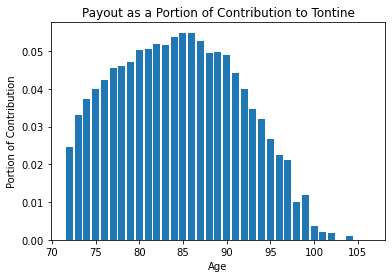

<Figure size 432x288 with 0 Axes>

In [11]:
mean_payout_tontine = []
for i in range(len(tontine_payouts[0])):
    boolArr = tontine_payouts[:,i] != None
    temp_payout = tontine_payouts[boolArr,i]
    if temp_payout.size != 0:
        mean_payout_tontine.append(np.mean(temp_payout))

payout_frac = np.array(mean_payout_tontine)/w_0
ages = np.arange(age_0, len(payout_frac)+age_0)
plt.bar(ages, payout_frac)
plt.title('Payout as a Portion of Contribution to Tontine')
plt.xlabel('Age')
plt.ylabel('Portion of Contribution')
plt.show()
plt.savefig('Analysis/payout_tontine.png')


In [12]:
# average amount withdrawn over 30 years
total_tontine_30 = np.mean(np.sum(tontine_payouts_30,axis = 1))

# average portion of contribution withdrawn each year over 30 years
mean_payout_tontine_30 = []
for i in range(len(tontine_payouts_30[0])):
    boolArr = tontine_payouts_30[:,i] != None
    temp_payout = tontine_payouts_30[boolArr,i]
    if temp_payout.size != 0:
        mean_payout_tontine_30.append(np.mean(temp_payout))
payout_frac_30 = np.array(mean_payout_tontine_30)/w_0
tontine_withdraw = np.mean(payout_frac_30)


In [13]:
# average amount withdrawn
total_tontine = 0
for i in range(len(tontine_payouts)):
    boolArr = tontine_payouts[i,:] != None
    temp_payout = tontine_payouts[i,boolArr]
    total_tontine += sum(temp_payout)
total_tontine = total_tontine/len(tontine_payouts)

In [14]:
# average monthly 1yr Tbill return
monthly_rf_tontine = ((np.mean(ir_mat)+1)**(1/12)-1)
# average annual tontine payout across 30 years
annual_avg_tontine = np.mean(np.mean(tontine_payouts_30 , axis = 0))
# profile
profile_header = ['Average Annual Withdrawal Amount Across 30 years', 'Withdrawal Rate',
                  'Average monthly RoR', 'Mean wealth after 30 years',
                  'Volatility of wealth at death', 'Probability of ruin in 30 years',
                  'Probability of ruin','Magnitude of ruin at 5th percentile']

profile_tontine = np.vstack((annual_avg_tontine , tontine_withdraw, monthly_rf_tontine, None, 0, 0, 0, None))
df_profile_tontine = pd.DataFrame(profile_tontine, index = profile_header, columns = ['Tontine'])
print(df_profile_tontine)

                                                     Tontine
Average Annual Withdrawal Amount Across 30 years     37892.8
Withdrawal Rate                                    0.0378928
Average monthly RoR                               0.00126487
Mean wealth after 30 years                              None
Volatility of wealth at death                              0
Probability of ruin in 30 years                            0
Probability of ruin                                        0
Magnitude of ruin at 5th percentile                     None


# SWR Conservative

In [15]:
asset_columns

['US Equities',
 'EAFE Equities',
 'EM Equities',
 'Leveraged Treasuries',
 'Corp Bonds',
 'TIPS(backfilled)',
 'Real Estate',
 'TSMOMPos',
 'T-bill']

In [16]:
imp.reload(strat)
swr = 0.04 # safe withdrawal rate
target_swrc = np.array ([[0 , 0, 0, .5, 0, .5, 0, 0, 0]]) .T # conservative : 100% in bonds, 50%-50% bonds
n_assets = 9
# 30 year time horizon
wealth_swrc, avg_returns_swrc, drawdowns_swrc = strat.wealth_path(age_0, scenarios, target_swrc, w_0,
                                                                  swr, inf_mat, n_assets, 30+age_0)
# uncertain time horizon
wealth_long_swrc, avg_returns_long_swrc, drawdowns_long_swrc = strat.wealth_path(age_0, scenarios, target_swrc,
                                                                           w_0, swr, inf_mat, n_assets, longevity)
# clean wealth
med_wealth_swrc = strat.clean_wealth(wealth_swrc)



/Users/danielthomas/Documents/GitHub/PostRetirement/strategies.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  drawdowns = np.array(drawdowns)


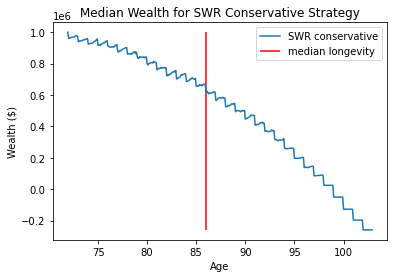

In [17]:
# plot median wealth path
x = np.arange(age_0-(1/12),((len(med_wealth_swrc)-1)/12)+age_0, 1/12)
plt.plot(x, med_wealth_swrc, label = 'SWR conservative')

plt.vlines(np.median(longevity), min(med_wealth_swrc), max(med_wealth_swrc), label = 'median longevity',
           color = 'r')
plt.title('Median Wealth for SWR Conservative Strategy')
plt.xlabel('Age')
plt.ylabel('Wealth ($)')
plt.legend()
plt.savefig('Analysis/med_wealth_swrc_4.png', bbox_inches='tight')

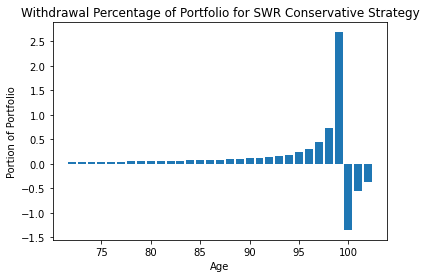

In [18]:
# plot withdrawal as a percentage of median portfolio wealth
yearly_wealth_swrc = med_wealth_swrc[::12]
avg_drawdowns_swrc = np.mean(drawdowns_swrc,axis = 0)
ages = np.arange(age_0, len(avg_drawdowns_swrc)+age_0)

plt.bar(ages, avg_drawdowns_swrc/yearly_wealth_swrc[:len(avg_drawdowns_swrc)])
plt.title('Withdrawal Percentage of Portfolio for SWR Conservative Strategy')
plt.xlabel('Age')
plt.ylabel('Portion of Portfolio')
plt.savefig('withdrawal_swrc_4pct.png', bbox_inches='tight')

In [22]:
imp.reload(strat)
percentile = 5
ruin_swrc, mag_swrc, mean_w_swrc, std_swrc = strat.profile(age_0, wealth_swrc, 30+age_0, percentile)
ruin_long_swrc, mag_long_swrc, mean_long_swrc = strat.p_ruin(age_0, wealth_long_swrc, longevity, percentile)
annual_avg_swrc = np.mean(avg_drawdowns_swrc)

# profile
profile_swrc = np.vstack((annual_avg_swrc, swr, np.mean(avg_returns_swrc), mean_w_swrc, std_swrc,
                          ruin_swrc, ruin_long_swrc, mag_long_swrc))

df_profile_swrc = pd.DataFrame(profile_swrc, index = profile_header, columns = ['SWR Conservative 3%'])
print(df_profile_swrc)

                                                  SWR Conservative 3%
Average Annual Withdrawal Amount Across 30 years         53484.016947
Withdrawal Rate                                              0.040000
Average monthly RoR                                          0.002060
Mean wealth after 30 years                             -218820.834227
Volatility of wealth at death                           323873.580323
Probability of ruin in 30 years                              0.840000
Probability of ruin                                          0.050000
Magnitude of ruin at 5th percentile                      25562.469876
